In [46]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [47]:
data=pandas.read_csv('subscription.csv')
# the company has 500000 users signing up for subcription in Jan, 2015
# the table contains information about when a user canceled the subscription
data

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0
...,...,...,...,...,...,...,...
499995,496962,"January, 2015",29,Spain,ads,2,0
499996,480669,"January, 2015",29,Italy,seo,1,0
499997,491164,"January, 2015",29,UK,ads,2,0
499998,493323,"January, 2015",49,Germany,ads,1,0


In [48]:
len(data['user_id'].unique())

500000

In [49]:
data.describe(include = 'all')

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
count,500000.000000,500000,500000.000000,500000,500000,500000.000000,500000.000000
unique,NaN,1,NaN,8,3,NaN,NaN
top,NaN,"January, 2015",NaN,US,ads,NaN,NaN
freq,NaN,500000,NaN,91731,414469,NaN,NaN
mean,250000.500000,NaN,48.469620,NaN,NaN,2.384970,0.099998
std,144337.711634,NaN,19.570745,NaN,NaN,2.254952,0.299998
min,1.000000,NaN,29.000000,NaN,NaN,1.000000,0.000000
25%,125000.750000,NaN,29.000000,NaN,NaN,1.000000,0.000000
50%,250000.500000,NaN,49.000000,NaN,NaN,1.000000,0.000000
75%,375000.250000,NaN,49.000000,NaN,NaN,3.000000,0.000000


In [50]:
# calculate monthly retention rate 
retention_rate =data.groupby(['subscription_monthly_cost', 'billing_cycles']).size().reset_index(name = 'count')

In [27]:
retention_rate

,subscription_monthly_cost,billing_cycles,count
0,29,1,57441
1,29,2,21818
2,29,3,12037
3,29,4,7787
4,29,5,5505
5,29,6,4136
6,29,7,3111
7,29,8,34527
8,49,1,185145
9,49,2,53296


In [51]:
# calculate churn rate as cumulative sum by billing cycle divided by total users
# retention rate =  1 - churn_rate
retention_rate['retention_rate'] = retention_rate.groupby('subscription_monthly_cost')['count'].transform(
                                               lambda x: 1-x.cumsum()/x.sum()
                                               )

In [52]:
# remove count and billing cycle == 8 because those users are still active
retention_rate= retention_rate.drop('count', axis = 1).query('billing_cycles < 8')
  


In [53]:
retention_rate

,subscription_monthly_cost,billing_cycles,retention_rate
0,29,1,0.607542
1,29,2,0.458473
2,29,3,0.376232
3,29,4,0.323028
4,29,5,0.285416
5,29,6,0.257157
6,29,7,0.235901
8,49,1,0.383666
9,49,2,0.206247
10,49,3,0.134043


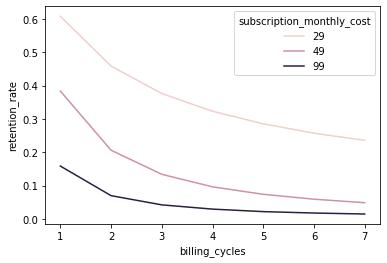

In [54]:
# The relationship is non-linear for all price options.  
sns.lineplot(x="billing_cycles", y="retention_rate", 
             hue="subscription_monthly_cost", data=retention_rate, legend="full"
             )
plt.show()

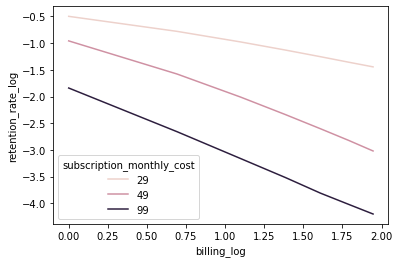

In [55]:
# the speed of churn decreases as billing cycles increases  
# log transformation
retention_rate["billing_log"] = np.log(retention_rate["billing_cycles"])

retention_rate["retention_rate_log"] = np.log(retention_rate["retention_rate"])

#plot 
sns.lineplot(x="billing_log", y="retention_rate_log", 
             hue="subscription_monthly_cost", data=retention_rate, legend="full"
             )
plt.show()

In [56]:
# model retention rate with linear regression  
# model for the price option of $29 
y29 = retention_rate.query('subscription_monthly_cost==29')['retention_rate_log']
X29 = retention_rate.query('subscription_monthly_cost==29')['billing_log']
X29 = sm.add_constant(X29)
  

In [57]:
model29 = sm.OLS(y29, X29)
results29 = model29.fit()
print("R Squared for 29$ is:", round(results29.rsquared,2))


R Squared for 29$ is: 0.99


In [59]:
#build linear model for price 49
y49 = retention_rate.query('subscription_monthly_cost==49')['retention_rate_log']
X49 = retention_rate.query('subscription_monthly_cost==49')['billing_log']
X49 = sm.add_constant(X49)
  
model49 = sm.OLS(y49, X49)
results49 = model49.fit()
print("R Squared for 49$ is:", round(results49.rsquared,2))


R Squared for 49$ is: 1.0


In [60]:
#build linear model for price 99
y99 = retention_rate.query('subscription_monthly_cost==99')['retention_rate_log']
X99 = retention_rate.query('subscription_monthly_cost==99')['billing_log']
X99 = sm.add_constant(X99)
  
model99 = sm.OLS(y99, X99)
results99 = model99.fit()
print("R Squared for 99$ is:", round(results99.rsquared,2))

R Squared for 99$ is: 1.0


In [61]:
# predict the retention rate for billing cycle > 8
Xpred = np.log(range(8,13))
Xpred = sm.add_constant(Xpred)
print(results29.predict(Xpred))

[-1.48549968 -1.54324007 -1.5948906  -1.64161419 -1.68426949]


In [62]:
print(np.exp(results29.predict(Xpred)))

[0.22638919 0.21368762 0.20293073 0.19366717 0.18557995]


In [66]:
print("For the 29$ price point, after 1 year, the retention rate will be", 
      round(np.exp(results29.predict(Xpred))[4], 3))
print("For the 49$ price point, after 1 year, the retention rate will be", 
      round(np.exp(results49.predict(Xpred))[4], 3))
print("For the 99$ price point, after 1 year, the retention rate will be", 
      round(np.exp(results99.predict(Xpred))[4], 3))

For the 29$ price point, after 1 year, the retention rate will be 0.186
For the 49$ price point, after 1 year, the retention rate will be 0.029
For the 99$ price point, after 1 year, the retention rate will be 0.008


In [67]:
# estimate the customer life time value
Xpred = np.log(range(1,13))
Xpred = sm.add_constant(Xpred)

#predict the retention rate for each billing cycle
retention_rate_tmp = np.exp(results29.predict(Xpred))

#calculate the expected value by multiplying each probability * corresponding money at each billing cycle.
LTV_29 = 29 + sum(retention_rate_tmp * 29)
print("Avg LTV of customers paying 29$ a month is:", round(LTV_29), "dollars")


Avg LTV of customers paying 29$ a month is: 132 dollars


In [68]:
retention_rate_tmp = np.exp(results49.predict(Xpred))
LTV_49 = 49 + sum(retention_rate_tmp * 49)
print("Avg LTV of customers paying 49$ a month is:", round(LTV_49), "dollars")

Avg LTV of customers paying 49$ a month is: 107 dollars


In [69]:

retention_rate_tmp = np.exp(results99.predict(Xpred))
LTV_99 = 99 + sum(retention_rate_tmp * 99)
print("Avg LTV of customers paying 99$ a month is:", round(LTV_99), "dollars")


Avg LTV of customers paying 99$ a month is: 139 dollars


Based on the prediction, the highest LTV is for users paying 99 dollars. However, considering that 29 has a much higher 1 year retention rate, if we had taken a larger time window to define LTV, 29 would have likely been the best one.

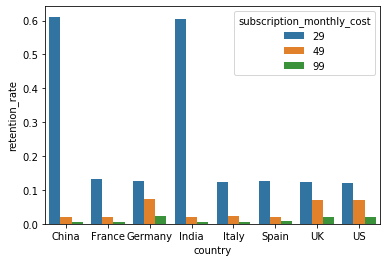

In [70]:
# look at the users who are still active after 8 month
#group by country and price and check retention rate as defined above
country_retention = data.groupby(['country', 'subscription_monthly_cost']).apply(
                    lambda x: pandas.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and country
                            'count': x['is_active'].count(),
                            # avg revenue by price and country
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
  })
).reset_index()
      

sns.barplot(x="country", hue="subscription_monthly_cost", y="retention_rate", data=country_retention)
plt.show()

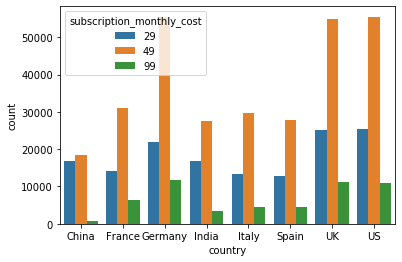

In [71]:
#plot user count by country and price
sns.barplot(x="country", hue="subscription_monthly_cost", y="count", data=country_retention)
plt.show()

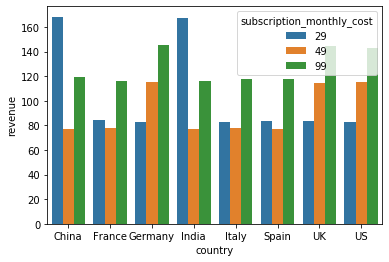

In [72]:
#find out for each country avg user revenue within the first 8 months
sns.barplot(x="country", hue="subscription_monthly_cost", y="revenue", data=country_retention)
plt.show()

China and India have huge retention rate for the cheapest price point. They are also much more likely to choose the 29$ option compared to the other countries


India and China best price point is the cheapest one. For all other countries, the best price point is the most expensive one. However, unfortunately, all countries have the highest proportion of subscribers for the middle price. Therefore, if the company could shift users towards the optimal price point, this would increase user LTV, and that would have several positive effects, beside the obvious revenue gain. For instance, higher LTV means that we could bid higher for ads, and therefore grow much faster



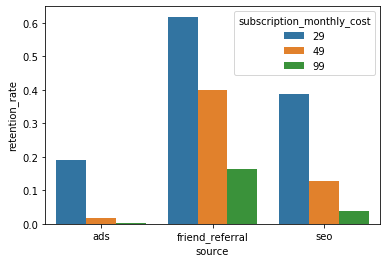

In [73]:
#group by source and price and check retention rate as defined above
source_retention = data.groupby(['source', 'subscription_monthly_cost']).apply(
                    lambda x: pandas.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and source
                            'count': x['is_active'].count(),
                            # avg revenue by price and source
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
  })
).reset_index()
      
#Let's plot retention rate by source and price
sns.barplot(x="source", hue="subscription_monthly_cost", y="retention_rate", data=source_retention)
plt.show()

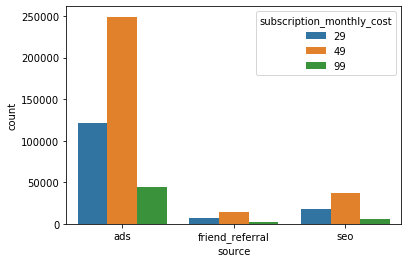

In [74]:
#Let's plot user count by source and price
sns.barplot(x="source", hue="subscription_monthly_cost", y="count", data=source_retention)
plt.show()

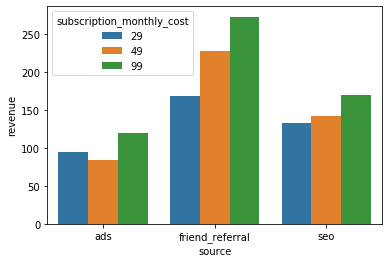

In [75]:

#Let's find out for each source avg user revenue within the first 8 months
sns.barplot(x="source", hue="subscription_monthly_cost", y="revenue", data=source_retention)
plt.show()

Findings:

The high majority of users is coming from ads. However, these users have the lowest retention and, consequently, the lowest LTV. Also, those ads are mainly attracting 49$ customers. That’s highly inefficient. Ads campaigns should be optimized to attract customers with higher likelihood of buying the optimal price point


In terms of retention, friend referral is doing really well, but has very low absolute numbers. Increasing this is a big opportunity. And btw the discount that is usually given to referred users can also be used as a leverage for the price discussion from above


SEO is also doing better than ads in terms of retention, but there are way less users. This is also a big opportunity, especially because SEO is the only one that doesn’t cost anything.


Overall these findings can be useful especially for marketing. We found several segments that are doing well, but are under represented as a proportion of total users. And these are by far the best/most actionable insights to give the marketing team.